https://www.nrdc.org/stories/what-air-quality-index?gad_source=1&gclid=Cj0KCQjw7Py4BhCbARIsAMMx-_IUy3ulnim_T29n4Y5MkysT7RblViSL2Jqv7HjvErXCtiPH-nq3-JUaAhEaEALw_wcB

https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt

# Cleaning up AQI data

In [12]:
import pandas as pd
import json
import polars as pl
import numpy as np

# Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
#statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.
#Here we use stats models to import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Pyproj Is a Python interface to PROJ (cartographic projections and coordinate transformations library). It is used for converting between different coordinate systems.
import pyproj
from pyproj import Geod

In order to start working with the AQA data, we will first load the Json files that we downloaded in the last notebook. Further, I will be merging the gaseos, AQI and particulate AQI data into a single data frame. This will help us further simplify the data cleaning process and standardize it for both the datasets.

In [13]:
#read gaseous_aqi json file
with open('./intermediate data files/gaseous_aqi.json') as f:
    gaseous_aqi = json.load(f)
    
#read particulate_aqi json file
with open('./intermediate data files/particulate_aqi.json') as f:
    particulate_aqi = json.load(f)


In [14]:
gaseous_aqi_df = pd.DataFrame(gaseous_aqi)
partcipate_aqi_df = pd.DataFrame(particulate_aqi)
aqi_full = pd.concat([gaseous_aqi_df, partcipate_aqi_df])

In [15]:
aqi_full_df = pl.from_pandas(aqi_full)

The AQI data contains a lot of attributes, however, will only be requiring a few of them here I am filtering out the required attributes and storing the in a new data frame

In [16]:
#gaesous_aqi_df.group_by('date_local','site_number','sample_duration','parameter','aqi').count()

column_names = ["state_code", "county_code", "site_number", "parameter_code",
                "latitude", "longitude", "parameter", "sample_duration",
                "date_local", "units_of_measure",
                "aqi", "arithmetic_mean",
                "first_max_value", "validity_indicator"]

#print("No. of rows in df_gaseous - ", len(df_gaseous))
aqi_df_slected = aqi_full_df.select(column_names)
aqi_df_slected

state_code,county_code,site_number,parameter_code,latitude,longitude,parameter,sample_duration,date_local,units_of_measure,aqi,arithmetic_mean,first_max_value,validity_indicator
str,str,str,str,f64,f64,str,str,str,str,f64,f64,f64,str
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""1 HOUR""","""1962-05-01""","""Parts per billion""",43.0,17.083333,30.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""1 HOUR""","""1962-05-02""","""Parts per billion""",29.0,13.333333,20.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""1 HOUR""","""1962-05-03""","""Parts per billion""",69.0,23.333333,50.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""1 HOUR""","""1962-05-04""","""Parts per billion""",94.0,23.913043,70.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""1 HOUR""","""1962-05-05""","""Parts per billion""",43.0,15.416667,30.0,"""Y"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""","""2024-06-26""","""Micrograms/cubic meter (LC)""",58.0,12.9,12.9,"""Y"""
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""","""2024-06-27""","""Micrograms/cubic meter (LC)""",26.0,4.6,4.6,"""Y"""
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""","""2024-06-28""","""Micrograms/cubic meter (LC)""",24.0,4.3,4.3,"""Y"""


Upon inspection, I saw that there are a few rows which are duplicates, so I am removing them. This brings down the size of the from around 600,000 to around 400,000.

In [17]:
#dropping duplicates
aqi_df_unique = aqi_df_slected.unique(keep="last", maintain_order=True)
aqi_df_unique

state_code,county_code,site_number,parameter_code,latitude,longitude,parameter,sample_duration,date_local,units_of_measure,aqi,arithmetic_mean,first_max_value,validity_indicator
str,str,str,str,f64,f64,str,str,str,str,f64,f64,f64,str
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""","""1962-05-01""","""Parts per billion""",null,17.075,23.3,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""","""1962-05-02""","""Parts per billion""",null,13.3125,20.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""","""1962-05-03""","""Parts per billion""",null,23.325,30.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""","""1962-05-04""","""Parts per billion""",null,24.257143,40.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""","""1962-05-05""","""Parts per billion""",null,15.3875,26.6,"""Y"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""","""2024-06-26""","""Micrograms/cubic meter (LC)""",58.0,12.9,12.9,"""Y"""
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""","""2024-06-27""","""Micrograms/cubic meter (LC)""",26.0,4.6,4.6,"""Y"""
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""","""2024-06-28""","""Micrograms/cubic meter (LC)""",24.0,4.3,4.3,"""Y"""


The AQI data contains a field called validity indicator, which is a boolean field. Since I already have enough data to connect the analysis, I am filtering out all the records where the validity indicator as false.

In [18]:
#filtering by validity indicator
aqi_df_unique = (
    aqi_df_unique.with_columns(pl.col("date_local").str.to_date())
    .filter(pl.col("validity_indicator") == 'Y')
)

aqi_df_unique

state_code,county_code,site_number,parameter_code,latitude,longitude,parameter,sample_duration,date_local,units_of_measure,aqi,arithmetic_mean,first_max_value,validity_indicator
str,str,str,str,f64,f64,str,str,date,str,f64,f64,f64,str
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""",1962-05-01,"""Parts per billion""",null,17.075,23.3,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""",1962-05-02,"""Parts per billion""",null,13.3125,20.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""",1962-05-03,"""Parts per billion""",null,23.325,30.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""",1962-05-04,"""Parts per billion""",null,24.257143,40.0,"""Y"""
"""42""","""101""","""0002""","""42401""",39.957513,-75.1735,"""Sulfur dioxide""","""3-HR BLK AVG""",1962-05-05,"""Parts per billion""",null,15.3875,26.6,"""Y"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""",2024-06-26,"""Micrograms/cubic meter (LC)""",58.0,12.9,12.9,"""Y"""
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""",2024-06-27,"""Micrograms/cubic meter (LC)""",26.0,4.6,4.6,"""Y"""
"""42""","""101""","""0048""","""88101""",39.991389,-75.080833,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""",2024-06-28,"""Micrograms/cubic meter (LC)""",24.0,4.3,4.3,"""Y"""


One interesting piece of information to look at would be the distance of each of the sites from the nearest city, this is being calculated using the pyproj Module in python. We are basically using the latitude and latitude of the site and the city and computing distance between them. This is stored in a new field called distance_from_city.

In [19]:
#find distance between each city and the site
geodcalc = Geod(ellps='WGS84')

def distance_in_miles(row):
    d = geodcalc.inv(
        -75.1652,
        39.9526,
        row["longitude"],
        row["latitude"]
    )
    # convert the distance to miles
    distance_in_miles = d[2] * 0.00062137
    return distance_in_miles

# Creating a new column in unique_stations to find the distance from the city
aqi_df_unique_1 = aqi_df_unique.with_columns(
    pl.struct(["longitude","latitude"])
    .map_elements(distance_in_miles, return_dtype=pl.Float64)
    .alias("distance_from_city")
)
# Sort the dataframe based on distance_from_city
aqi_df_unique_2 = (
    aqi_df_unique_1
      .sort("distance_from_city")
)
aqi_df_unique_2

state_code,county_code,site_number,parameter_code,latitude,longitude,parameter,sample_duration,date_local,units_of_measure,aqi,arithmetic_mean,first_max_value,validity_indicator,distance_from_city
str,str,str,str,f64,f64,str,str,date,str,f64,f64,f64,str,f64
"""42""","""101""","""0025""","""42101""",39.951402,-75.164055,"""Carbon monoxide""","""1 HOUR""",1974-05-01,"""Parts per million""",null,3.041667,8.0,"""Y""",0.102606
"""42""","""101""","""0025""","""42101""",39.951402,-75.164055,"""Carbon monoxide""","""1 HOUR""",1974-05-02,"""Parts per million""",null,2.875,6.0,"""Y""",0.102606
"""42""","""101""","""0025""","""42101""",39.951402,-75.164055,"""Carbon monoxide""","""1 HOUR""",1974-05-03,"""Parts per million""",null,4.875,10.0,"""Y""",0.102606
"""42""","""101""","""0025""","""42101""",39.951402,-75.164055,"""Carbon monoxide""","""1 HOUR""",1974-05-04,"""Parts per million""",null,2.291667,5.0,"""Y""",0.102606
"""42""","""101""","""0025""","""42101""",39.951402,-75.164055,"""Carbon monoxide""","""1 HOUR""",1974-05-05,"""Parts per million""",null,2.25,4.0,"""Y""",0.102606
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""42""","""101""","""0075""","""88101""",40.054171,-74.985166,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""",2024-06-26,"""Micrograms/cubic meter (LC)""",53.0,10.0,10.0,"""Y""",11.847184
"""42""","""101""","""0075""","""88101""",40.054171,-74.985166,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""",2024-06-27,"""Micrograms/cubic meter (LC)""",28.0,5.1,5.1,"""Y""",11.847184
"""42""","""101""","""0075""","""88101""",40.054171,-74.985166,"""PM2.5 - Local Conditions""","""24-HR BLK AVG""",2024-06-28,"""Micrograms/cubic meter (LC)""",27.0,4.8,4.8,"""Y""",11.847184


This is where most of the Data aggregation is happening. First, I am removing all the values from the AQI data. Then I'm grouping by the date, site number and parameter. While performing this grouping, I am aggregating based on the mean of the values. Next, I am merging the parameter values. The parameter values in the data show the various pollutants for which the AQI has been calculated for a given day and site number. Since at a given site, the AQI of the most Toxic pollutant makes most sense, I am aggregating on the maximum of the AQI here. 
Finally, I am emerging all all data for a particular year. I am aggregating the AQI values at this point using the mean. 

For merging the site numbers, I initially wanted to use a weighted average of the distances from the city however, I realize that since this data is from a long time, the boundaries of the cities might have changed in the last 60 years and our current center of the city might not be an accurate representation for the entirety of the 60 year period. Hence, in order to not overcomplicate The analysis I am just sticking with the main of the site numbers.

Finally, I am filtering the year to have ranges between 1960 and 2020 as required in the problem statement.

In [20]:
aqi_df_unique_3 = (
    aqi_df_unique
    .with_columns(
        pl.col("aqi").is_null().name.suffix("_isnull")
        )
    .filter(
        pl.col("aqi_isnull") == False
        )
    .group_by("date_local","site_number","parameter").mean()
    #max parameter value taken as AQI value
     .group_by("date_local","site_number").max().sort("date_local")
    # #mean for that specific year
    .group_by("site_number",pl.col("date_local").dt.year()).mean().sort("date_local")
    # # #weighted mean for each site by distance
    #  .with_columns((pl.col("aqi")*(1/pl.col("distance_from_city"))).alias("weighted_aqi_by_site_dist"))
    #  .group_by("date_local").sum()
    #  .with_columns((pl.col("weighted_aqi_by_site_dist")/pl.col("distance_from_city")).alias("consolidated_aqi"))
    .group_by("date_local").mean()
    .filter(pl.col("date_local") >= 1960)
    .filter(pl.col("date_local") <= 2020)
    .sort("date_local")
)
aqi_df_unique_3

date_local,site_number,parameter,state_code,county_code,parameter_code,latitude,longitude,sample_duration,units_of_measure,aqi,arithmetic_mean,first_max_value,validity_indicator,distance_from_city,aqi_isnull
i32,str,str,str,str,str,f64,f64,str,str,f64,f64,f64,str,f64,f64
1962,null,null,null,null,null,39.957513,-75.1735,null,null,50.820896,21.520494,45.671642,null,0.555976,0.0
1963,null,null,null,null,null,39.957513,-75.1735,null,null,108.190476,58.438958,155.62381,null,0.555976,0.0
1964,null,null,null,null,null,39.957513,-75.1735,null,null,124.554348,53.135845,129.127717,null,0.555976,0.0
1965,null,null,null,null,null,39.957513,-75.1735,null,null,142.156,73.896767,194.572,null,0.555976,0.0
1966,null,null,null,null,null,39.983201,-75.13564,null,null,107.921196,42.68961,104.961413,null,2.918393,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016,null,null,null,null,null,40.000371,-75.10178,null,null,43.381531,10.084744,14.227673,null,5.877883,0.0
2017,null,null,null,null,null,40.000371,-75.10178,null,null,39.68639,8.725729,10.97053,null,5.877883,0.0
2018,null,null,null,null,null,40.000371,-75.10178,null,null,43.317079,8.033153,9.876147,null,5.877883,0.0


Boloco has been committed out because it is just some additional information that I was using to better understand the data.

In [21]:
#  tester = (
#     df_gaseous_unique
#     .with_columns(
#         pl.col("aqi").is_null().name.suffix("_isnull")
#         )
#     .filter(
#         pl.col("aqi_isnull") == False
#         )
#     .group_by(
#         "date_local"
#           ).count().sort("date_local")
#     )

In [22]:
# df_unique_1 = (
#     df_gaseous_unique
#     .with_columns(
#         pl.col("aqi").is_null().name.suffix("_isnull")
#         )
#     .filter(
#         pl.col("aqi_isnull") == False
#         )
#     .group_by(pl.col("date_local").dt.year()).mean()
#     .sort("date_local")

#     )

### Plotting the AQI data over the years

I am plotting the AQI data over the years to see how the AQI has changed over the years. This is a simple line plot with the year on the x-axis and the AQI on the y-axis. The AQI is the average AQI for all the sites in a given year.

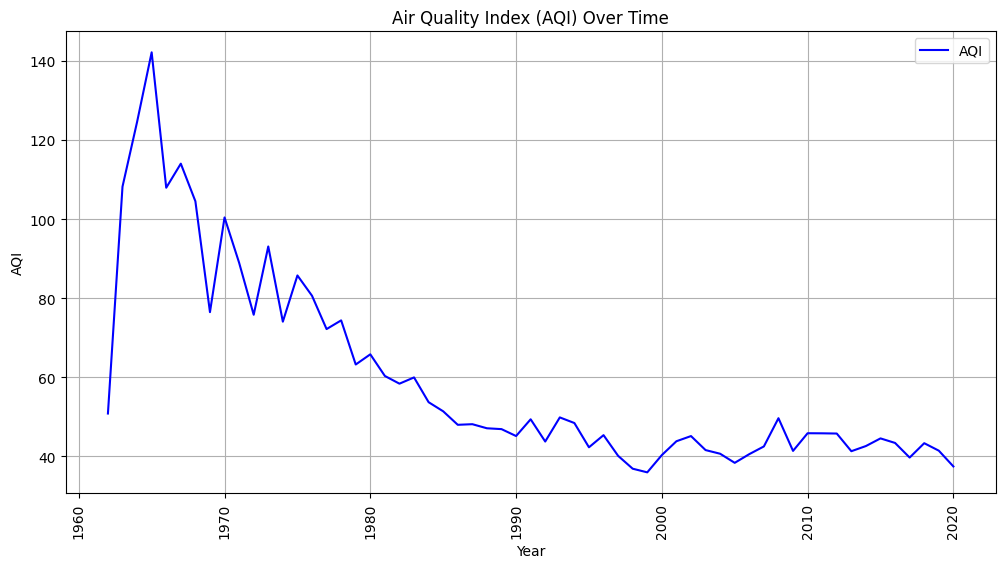

In [36]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the AQI data
plt.plot(aqi_df_unique_3["date_local"], aqi_df_unique_3["aqi"], label='AQI', color='b')

# Set the title and labels
plt.title('Air Quality Index (AQI) Over Time')
plt.xlabel('Year')
plt.ylabel('AQI')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add a grid for better readability
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()


# #draw a time series graph for date_local as year and aqi
# plt.plot(aqi_df_unique_3["date_local"], aqi_df_unique_3["aqi"])
# plt.xticks(rotation=90)
# plt.show()

# Analysing the wildfire data

The wildfire data has been obtained from the first notebook. I am loading the data here And cleaning the data.

In [25]:
import json
#read fire_distance_data.json file
with open('./intermediate data files/fire_distance_data.json') as f:
    fire_distance_data = json.load(f)

In [26]:
len(fire_distance_data['values'])

135033

In [27]:
pandas_fires = pd.DataFrame(fire_distance_data['values'])
pandas_fires

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Listed_Map_Digitize_Methods,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,shortest_dist,avg_dist
0,1,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Other (1),None,None,0.047590,NaN,No,64888.449849,1.594545e+07,"[2409.963449983856, [47.84027067710629, -123.0...",2412.263443
1,2,2,Wildfire,1860,1,1 (1),772.518249,312.627044,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Other (1),None,None,0.071367,NaN,No,23462.288613,3.126270e+06,"[2411.1759177274416, [47.778839894458905, -123...",2412.226341
2,3,3,Wildfire,1860,1,1 (1),333.020409,134.768578,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,Other (1),None,None,0.379578,NaN,No,6679.573569,1.347686e+06,"[2412.855530703217, [47.786737441812576, -123....",2413.342300
3,4,4,Wildfire,1870,1,"1 (1), 3 (1)",22294.993577,9022.463795,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",...,Unknown (1),None,None,0.158038,NaN,No,84700.719226,9.022464e+07,"[2073.3199941326716, [46.009602191305625, -115...",2075.348768
4,5,5,Wildfire,1870,1,"1 (1), 3 (1)",36.985574,14.967531,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (1)",...,Digitized Other (1),None,None,0.218009,NaN,No,2937.265383,1.496753e+05,"[2015.0028108127563, [43.924461980917734, -114...",2015.106576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135028,135057,135057,Prescribed Fire,2020,8,8 (3),16.412148,6.641761,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (3),...,None,None,"Caution, this Prescribed Fire in 2020 overlaps...",0.177425,NaN,No,2168.900740,6.641761e+04,"[2442.38320833583, [43.74412279749511, -122.88...",2442.484093
135029,135058,135058,Prescribed Fire,2020,8,8 (1),7.050837,2.853373,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,None,None,"Caution, this Prescribed Fire in 2020 overlaps...",0.374368,NaN,No,978.666221,2.853373e+04,"[2201.7530395619774, [44.010277595941865, -118...",2201.863707
135030,135059,135059,Prescribed Fire,2020,8,8 (4),9.342668,3.780843,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (4),...,None,None,"Caution, this Prescribed Fire in 2020 overlaps...",0.123888,NaN,No,1958.326660,3.780843e+04,"[2202.1467081258147, [43.99679011913212, -118....",2202.180518
135031,135060,135060,Prescribed Fire,2020,8,8 (1),0.996962,0.403456,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,None,None,None,0.993809,1.0,No,225.866452,4.034562e+03,"[1768.1875941923192, [40.60490490521522, -108....",1768.209860


The API returns the shortest distance as an list. The first index of the list contains the shortest distance and second index contains a lat long pair. Using the below function, I am replacing the shortest distance column to just contain the shortest distance.

In [28]:
def replace_shortest_dist(row):
    if len(row['shortest_dist']) > 0:
        return row['shortest_dist'][0]
    else:
        return None
pandas_fires['shortest_dist'] = pandas_fires.apply(replace_shortest_dist, axis=1)


In [29]:
fires_df = pl.from_pandas(pandas_fires)

After looking into the file provided on the government website, which contains all the meta-data about the data one interesting call him that I found was the Assign_fire_type. The documentation also mentioned that most of the fires that were of a large scale were actually wild fires. Hence, it is logical to me to use this Field. However, for the purposes of the analysis giving a numeric value to these fields would be more useful. Hence, I am converting the fire type to a numeric value. I am assigning the highest values of 5 to the wildfires and the lowest value of 1 to the prescribed burns. This is because the prescribed burns are the least harmful to the environment and the wildfires are the most harmful.

In [30]:
fire_severity = {}
fire_severity['Unknown - Likely Prescribed Fire'] = 1
fire_severity['Prescribed Fire'] = 2
fire_severity['Unknown - Likely Wildfire'] = 3
fire_severity['Likely Wildfire'] = 4
fire_severity['Wildfire'] = 5

def fire_severity_assignment(val):
    return fire_severity[val]

In [31]:
fires_df = (
    fires_df
    .with_columns(
        pl.col("Assigned_Fire_Type").map_elements(fire_severity_assignment).alias("Fire_Severity")
    )
)
fires_df

/var/folders/9k/b_vy9rw147729qrz8n_rjjl00000gn/T/ipykernel_55432/1960913691.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  fires_df


OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,Listed_Fire_Codes,Listed_Fire_IDs,Listed_Fire_IRWIN_IDs,Listed_Fire_Dates,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Rx_Reported_Acres,Listed_Map_Digitize_Methods,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,shortest_dist,avg_dist,Fire_Severity
i64,i64,str,i64,i64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,i64
1,1,"""Wildfire""",1860,1,"""1 (1)""",3940.207089,1594.545237,"""Comb_National_NIFC_Interagency…","""Wildfire (1)""","""Big Quilcene River (1)""","""No code provided (1)""","""""","""""","""Listed Other Fire Date(s): 200…","""""","""Undetermined (1)""",null,"""Other (1)""",null,null,0.04759,null,"""No""",64888.449849,1.5945e7,2409.96345,2412.263443,5
2,2,"""Wildfire""",1860,1,"""1 (1)""",772.518249,312.627044,"""Comb_National_NIFC_Interagency…","""Wildfire (1)""","""Harrison Lake (1)""","""No code provided (1)""","""""","""""","""Listed Other Fire Date(s): 200…","""""","""Undetermined (1)""",null,"""Other (1)""",null,null,0.071367,null,"""No""",23462.288613,3.1263e6,2411.175918,2412.226341,5
3,3,"""Wildfire""",1860,1,"""1 (1)""",333.020409,134.768578,"""Comb_National_NIFC_Interagency…","""Wildfire (1)""","""Tunnel Creek (1)""","""No code provided (1)""","""""","""""","""Listed Other Fire Date(s): 200…","""""","""Undetermined (1)""",null,"""Other (1)""",null,null,0.379578,null,"""No""",6679.573569,1.3477e6,2412.855531,2413.3423,5
4,4,"""Wildfire""",1870,1,"""1 (1), 3 (1)""",22294.993577,9022.463795,"""Comb_National_NIFC_Interagency…","""Wildfire (1), Likely Wildfire …","""1870 (2)""","""No code provided (2)""","""1870-IDNCF- (1)""","""""","""Listed Other Fire Date(s): 201…","""""","""Undetermined (2)""",null,"""Unknown (1)""",null,null,0.158038,null,"""No""",84700.719226,9.0225e7,2073.319994,2075.348768,5
5,5,"""Wildfire""",1870,1,"""1 (1), 3 (1)""",36.985574,14.967531,"""Comb_National_NIFC_Interagency…","""Wildfire (1), Likely Wildfire …","""No Fire Name Provided (2)""","""No code provided (2)""","""""","""""","""""","""""","""Undetermined (2)""",null,"""Digitized Other (1)""",null,null,0.218009,null,"""No""",2937.265383,149675.305977,2015.002811,2015.106576,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
135057,135057,"""Prescribed Fire""",2020,8,"""8 (3)""",16.412148,6.641761,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (3)""","""WEW CA Broadcast (3)""","""No code provided (3)""","""NFPORS6319933 (3)""",null,"""Listed Prescribed Fire End Dat…","""Human (3)""","""Human (3)""",null,null,null,"""Caution, this Prescribed Fire …",0.177425,null,"""No""",2168.90074,66417.60679,2442.383208,2442.484093,2
135058,135058,"""Prescribed Fire""",2020,8,"""8 (1)""",7.050837,2.853373,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (1)""","""2_PHMA_FIAT_Beulah_East_Bendir…","""No code provided (1)""","""NFPORS6318576 (1)""",null,"""Listed Prescribed Fire End Dat…","""Human (1)""","""Human (1)""",null,null,null,"""Caution, this Prescribed Fire …",0.374368,null,"""No""",978.666221,28533.725602,2201.75304,2201.863707,2
135059,135059,"""Prescribed Fire""",2020,8,"""8 (4)""",9.342668,3.780843,"""Comb_National_Rx_Only_BLM_VTRT…","""Prescribed Fire (4)""","""2_PHMA_FIAT_Beulah_East_Bendir…","""No code provided (4)""","""NFPORS6318576 (4)""",null,"""Listed Prescribed Fire End Dat…","""Human (4)""","""Human (4)""",null,null,null,"""Caution, this Prescribed Fire …",0.123888,null,"""No""",1958.32666,37808.434086,2202.146708,2202.180518,2


### Smoke estimate
 Next, we are required to create an estimate of smoke in the city. This is quite interesting because There can be multiple factors that lead to smoke in the city and we might or might not have all of them in the wildfire data. However, an important thing to note is that since the wildfires are very big and harmful, they might provide a good estimate of smoke in the city hence, in order to create an estimate of smoking in the city, I look through the metadata file to understand what are the different fields that I can use.

 Upon inspection, a few things that stood out to me was 
 1. the GIS_acres: This is the area of acres, where there was fire. I felt that this could be a very good estimate since the amount of acres burnt Can be a good estimate of the amount of smoke that was generated during the timeframe.
 2. The Fire severity score: The fire severity score also gives a clear indication of amount of smoke generated given that wildfires are the worst. They tend to emit more smoke. Hence, I feel this is a very important estimate. With Trial and error, I found that squaring the fire severity made the estimate better.
 3. The shortest distance: While the shortest distance from the wildfire to the city might not be accurate in all cases as stated above during my Aggregation process I feel it is still a good estimate as the amount of smoke observed in the city will be less if the wildfire was farther away from the city hence I use an inversion of the shortest distance to penalize The fires that are closest to the city as they will be giving more AQI.

 Hence, the formula that I Came up with for estimating smoke is as follows:
    smoke = GIS_acres * (fire_severity^2) * (1/shortest_distance)
    
Finally, I am filtering the data to have only the years between 1960 and 2020 as required in the problem statement.
I am also Filtering the data to have only the wildfires that are less than 650 miles away from the city. This is as required in the problem statement.

In [115]:
fires_acres_groupby = (
    fires_df
    .filter(pl.col("shortest_dist") <= 650)

    .with_columns(
        ((pl.col("GIS_Acres")*(1/pl.col("shortest_dist"))*(pl.col("Fire_Severity")**2))).alias("smoke_metric")
    )
.group_by("Fire_Year")
.agg(
    pl.col("smoke_metric").mean(),
    pl.col("GIS_Acres").sum(),
    pl.col("Shape_Area").sum(),
    pl.col("Circleness_Scale").mean(),
    pl.col("avg_dist").mean()
)
    .filter(pl.col("Fire_Year") >= 1962)
    .sort("Fire_Year")
)
fires_acres_groupby

Fire_Year,smoke_metric,GIS_Acres,Shape_Area,Circleness_Scale,avg_dist
i64,f64,f64,f64,f64,f64
1962,34.081084,2101.256034,8.5035e6,0.433719,357.811517
1963,13.07129,612.935299,2.4805e6,0.537208,267.602894
1964,0.695634,34.603416,140035.054476,0.780187,311.102256
1965,0.538599,69.677826,281976.159063,0.862893,293.668156
1966,0.2767,45.02889,182225.452987,0.917824,356.20598
…,…,…,…,…,…
2016,33.456501,450552.632497,1.8233e9,0.435272,482.946104
2017,20.416088,180054.397774,7.2865e8,0.406029,470.429336
2018,7.992868,215944.695898,8.7390e8,0.395005,482.735899


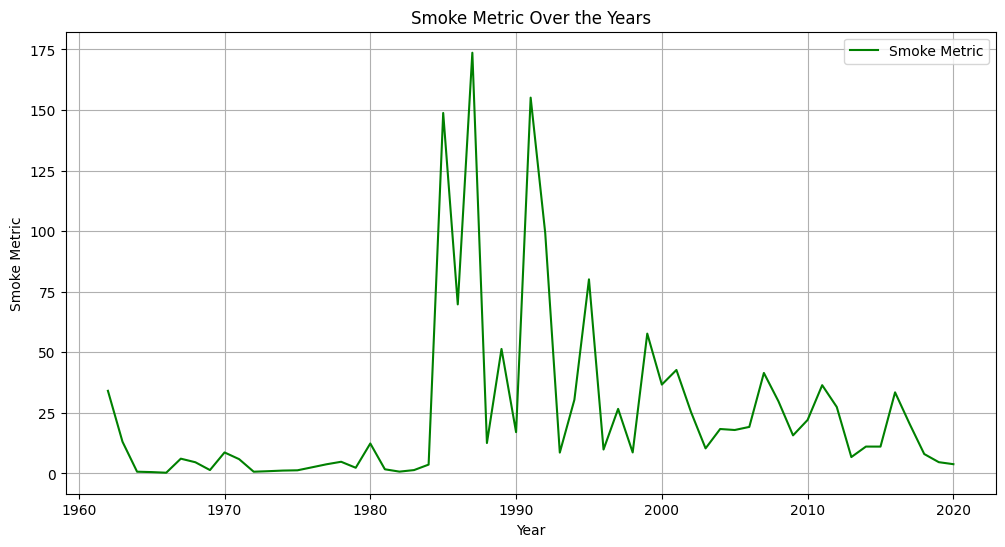

In [116]:
plt.figure(figsize=(12, 6))

# Plot the smoke metric
plt.plot(fires_acres_groupby["Fire_Year"], fires_acres_groupby["smoke_metric"], color='g', label='Smoke Metric')

# Set the title and labels
plt.title('Smoke Metric Over the Years')
plt.xlabel('Year')
plt.ylabel('Smoke Metric')

# Add a legend
plt.legend()

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

## Visualizations

### Chart 1
Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.


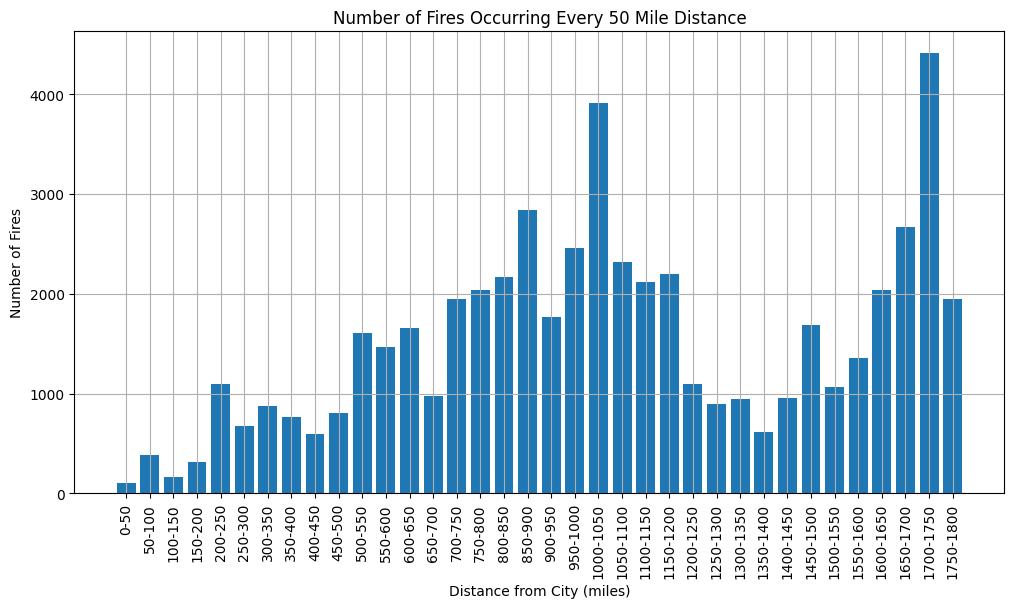

In [117]:
#Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.
fires_50_mile = (
    fires_df
    .filter(pl.col("shortest_dist") <= 1800)
    .with_columns(
        pl.col("shortest_dist")//50
    ).group_by("shortest_dist").count().sort("shortest_dist")
    
)
fires_50_mile

#draw a histogram for fires_50_mile
plt.figure(figsize=(12, 6))
plt.bar(fires_50_mile["shortest_dist"], fires_50_mile["count"])
#values on x axis should show 0-50, 51-100, ...
a = fires_50_mile["shortest_dist"]
plt.xticks(fires_50_mile["shortest_dist"], [f"{int(a[i]*50)}-{int(a[i]*50)+50}" for i in range(len(a))])
plt.xticks(rotation=90)
plt.xlabel('Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.title('Number of Fires Occurring Every 50 Mile Distance')
plt.show()



The figure shows the number of fires that were there for every 50 mile distance for the city of Philadelphia in the state of Pennsylvania. The histogram shows the number of fires that occurred at a distance of 50 miles, 100 miles, 150 miles and so on from the city of Philadelphia. As mentioned in the assignment, I have used a distance cut off of 1800 miles. This means that all the fires that are more than 1800 miles away from the city of Philadelphia have been removed from the data. The axis shows the distance From the city in miles and is grouped for every 50 miles. The Y axis shows the number of fires that have occurred over the years for each bin. The data for this graph comes from the wildlife data that was taken from the government website the retrieve using the APA provided and code can be found in the first notebook. The shortest distance was computed using the pyproj module in python. After filtering out the Distance is above 1800 miles the data was grouped for every 50 miles and the count of the fires was taken bin wise. Using Python's matplotlib library I was able to plot this histogram. 

The figure seems to Suggest that many of the fires that were very near the city were actually less in comparison to the fires that were farther away from the city one recent this could have been is because the cities are urban areas and have less forest in general and places outside the cities might have more for us and that might explain more fires there. Also using the same hypothesis, I suspect that I don't 50 to 1500 miles away from the city. There are fewer fires likely because there are other cities in the distance. However, this is just a hypothesis and I would need more data to confirm this.

### Chart 2: 
Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.


In [118]:
tot_acres_df = (
    fires_df
    .filter(pl.col("shortest_dist") <= 650)
    .group_by("Fire_Year")
    .agg(
        pl.col("GIS_Acres").sum()
        )
    .sort("Fire_Year")
    .filter(pl.col("Fire_Year") >= 1960)
)
tot_acres_df

Fire_Year,GIS_Acres
i64,f64
1960,67.78774
1961,159.401686
1962,2101.256034
1963,612.935299
1964,34.603416
…,…
2016,450552.632497
2017,180054.397774
2018,215944.695898


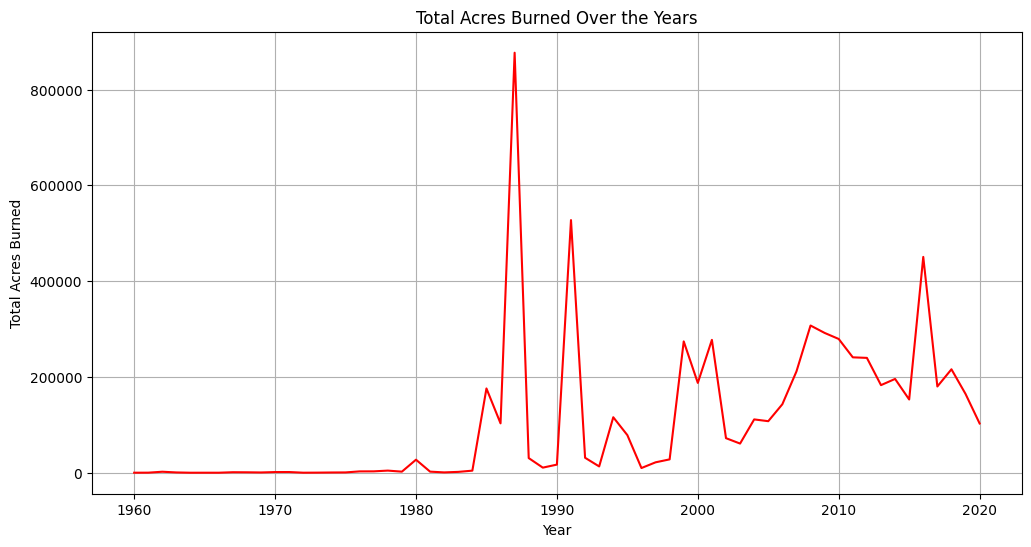

In [119]:
# #Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
plt.figure(figsize=(12, 6))
plt.plot(tot_acres_df["Fire_Year"], tot_acres_df["GIS_Acres"], color='r', label='Total Acres Burned')
plt.title('Total Acres Burned Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.grid(True)

Chart 2 depicts the total areas burnt over the years. The x-axis Show us the year from the year 1960 to the year 2020 the Y axis shows the Total number of acres burned in a particular area. The rate of this graph comes from the wild fire data that is taken from the government website. For a given year, the graph can be read by looking at the Y axis and seeing the total number of acres that were burnt in that year. The data for this graph too was fetched, using an API and the code for this can be found in the first notebook. The same data, cleaning steps written above, were used for this as well. The grouping and aggregations, however were different for this case. First, I filled out the Fires that were over 650 miles away from the city next a group the data by year and aggregated the number of acres column, which is required to show the Y axis by the sum of the number of acres finally I sorted the data by the ear and filtered out the years that were before 1960.

The figure shows the number of acres burnt has been increasing over the years. Particularly till the year 1985 it looks like very few acres burnt were recorded. This is consistent with the fact that the data might not have been recorded properly in the early years. This also means that before 1985 the smoke estimates that were calculated might be very often because of lack of data. Further, the data shows a very high peak for the total number of acres burned around 1985 to 1995. It will be interesting to find out what caused they peak.


### Chart 3:
Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.



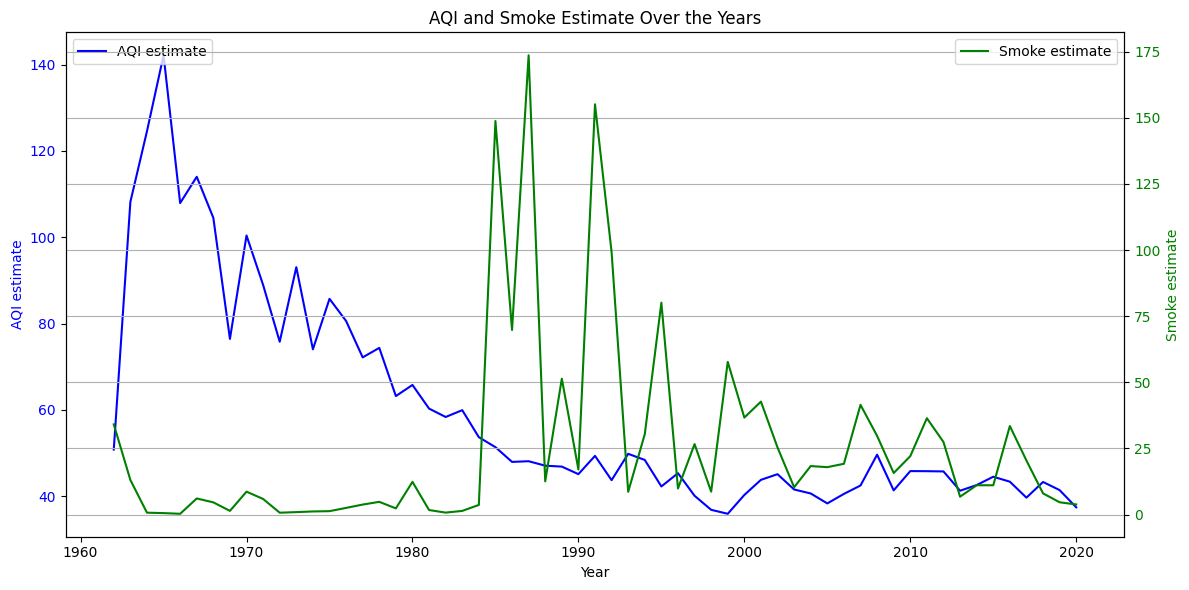

In [120]:
# Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the AQI data on the first y-axis
ax1.plot(aqi_df_unique_3["date_local"], aqi_df_unique_3["aqi"], color='b', label='AQI estimate')
ax1.set_xlabel('Year')
ax1.set_ylabel('AQI estimate', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the smoke estimates
ax2 = ax1.twinx()
ax2.plot(fires_acres_groupby["Fire_Year"], fires_acres_groupby["smoke_metric"], color='g', label='Smoke estimate')
ax2.set_ylabel('Smoke estimate', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add a title and grid
plt.title('AQI and Smoke Estimate Over the Years')
fig.tight_layout()
plt.grid(True)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

The figure shows a dual axis chart of the the AQI and the smoke estimates for the city of Philadelphia. A dual axis chart is a chart which has 2Y axis here we have utilized one by axis for the AQA estimate and the other Y axis for the smoke estimate. The x-axis shows the year from 1960 to 2020. The graph can be red by seeing the AQI estimate which is in blue color on the left side of the Y axis, and by reading the smoke estimate which on the right side of the Y axis to understand the green lines. AQI is the average AQI for all the sites in the city of Philadelphia. The smoke estimate is the estimate of the amount of smoke that was there in the city because of the wildfires. The data for this graph comes from the AQI data and the wildfire data that was taken from the government website. The data was cleaned and aggregated as mentioned above. 

The smoke estimate was calculated using the formula mentioned above. The data was then grouped by year and the AQI and the smoke estimates were aggregated by the mean. The data was then sorted by the year and the years before 1960 were filtered out. The data was then plotted using the matplotlib library in python. The figure shows are very interesting trend first for the years from 1960 to 1985. There seems to be no correlation whatsoever between the AQA estimate and the smoke estimate. I feel this is consistent with the fact that the data for the wildfires for these Years is very poorly maintained leading to incorrect estimate values. Also, the AQI values for early years were not vetted thoroughly as stated by the professor in the class. Next looking at the trend between 1985 and 1995 it looks like there is a small correlation between the peaks in in both estimates. However, the smoke estimate is quite high as compared to the estimate and I don't think they are correlated. I tried to do some initial Analysis to see why this might be the case however, I have not found anything as yet. 

Finally, the trend from 1995 to 2020 seems to have good correlation and the peaks seem to match in both cases. Check the graphs below where I am showing only 20 years of data. that One interesting fact to note is that for some years When the smoke estimate seems to go up, the QA estimate seems to also raise in the subsequent year. One of the reasons this might happen in my opinion is that since we're taking data between May and October, the smoke readings might only be visible in the subsequent year. Also, we saw in graph 1 that many of the fires were actually further away from the city and Estimate of 650 miles might not be very accurate as many large fires are father distance from the city.

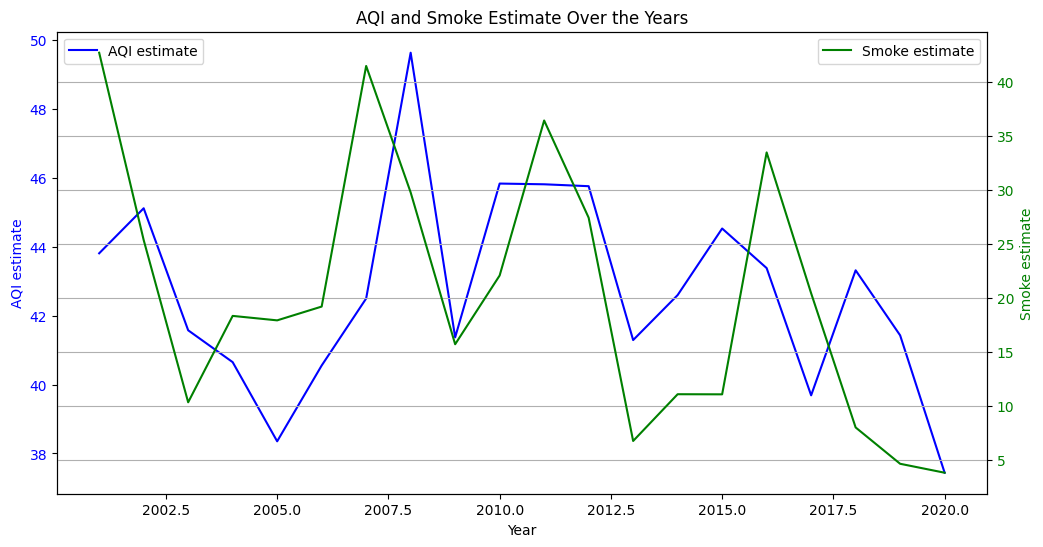

In [121]:
# Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the AQI data on the first y-axis
ax1.plot(aqi_df_unique_3["date_local"][-20:], aqi_df_unique_3["aqi"][-20:], color='b', label='AQI estimate')
ax1.set_xlabel('Year')
ax1.set_ylabel('AQI estimate', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the smoke estimates
ax2 = ax1.twinx()
ax2.plot(fires_acres_groupby["Fire_Year"][-20:], fires_acres_groupby["smoke_metric"][-20:], color='g', label='Smoke estimate')
ax2.set_ylabel('Smoke estimate', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add a title and grid
plt.title('AQI and Smoke Estimate Over the Years')
plt.grid(True)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [122]:
from scipy.stats import pearsonr

corr, _ = pearsonr(aqi_df_unique_3["aqi"][-20:], fires_acres_groupby["smoke_metric"][-20:])

print("Pearson-Correlation-Coefficient:", corr.round(2))


Pearson-Correlation-Coefficient: 0.49


The above two cells have very interesting results. I have filtered out the years before 2000 to check if there is any association between AQI and wildfire in recent times. Looks like there is indeed a correlation between the two. Even from the graph salon, we can see that the peaks and the dips are very similar in both the cases. This is a very interesting observation and I would like to explore this further.

ARIMA

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [91]:
model = ARIMA(fires_acres_groupby["smoke_metric"].to_pandas())
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           smoke_metric   No. Observations:                   61
Model:                          ARIMA   Log Likelihood                -213.748
Date:                Wed, 30 Oct 2024   AIC                            431.496
Time:                        17:52:14   BIC                            435.717
Sample:                             0   HQIC                           433.150
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8240      2.068      2.816      0.005       1.770       9.878
sigma2        64.7321     11.052      5.857      0.000      43.071      86.393
Ljung-Box (L1) (Q):                   7.10   Jarque-

In [136]:
fires_acres_groupby

Fire_Year,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,Listed_Fire_Codes,Listed_Fire_IDs,Listed_Fire_IRWIN_IDs,Listed_Fire_Dates,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Rx_Reported_Acres,Listed_Map_Digitize_Methods,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,shortest_dist,avg_dist,Fire_Severity,smoke_metric
i64,f64,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64
1962,38120.0,38120.0,null,1.666667,null,700.418678,283.449382,null,null,null,null,null,null,null,null,null,null,null,null,null,0.433719,null,null,9703.430973,2.8345e6,357.074978,357.811517,4.666667,8.26734
1963,28783.2,28783.2,null,1.4,null,122.58706,49.609223,null,null,null,null,null,null,null,null,null,null,null,null,null,0.537208,null,null,2949.317152,496092.229998,267.338248,267.602894,4.8,2.741624
1964,14825.333333,14825.333333,null,1.0,null,11.534472,4.667835,null,null,null,null,null,null,null,null,null,null,null,null,null,0.780187,null,null,715.933769,46678.351492,311.037987,311.102256,5.0,0.139127
1965,15045.454545,15045.454545,null,1.0,null,6.334348,2.56342,null,null,null,null,null,null,null,null,null,null,null,null,null,0.862893,1.0,null,521.628275,25634.196278,293.620283,293.668156,5.0,0.10772
1966,23297.888889,23297.888889,null,1.222222,null,5.00321,2.024727,null,null,null,null,null,null,null,null,null,null,null,null,null,0.917824,1.0,null,444.045566,20247.272554,356.165923,356.20598,4.888889,0.057734
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016,100883.065026,100883.065026,null,4.56942,null,791.832395,320.443201,null,null,null,null,null,null,null,null,null,null,null,null,null,0.435272,1.0,null,8407.673082,3.2044e6,482.436754,482.946104,3.217926,7.422158
2017,110081.284932,110081.284932,null,5.586301,null,493.29972,199.631314,null,null,null,null,null,null,null,null,null,null,null,null,null,0.406029,null,null,7514.02802,1.9963e6,470.000463,470.429336,2.671233,5.154008
2018,116212.969048,116212.969048,null,6.202381,null,514.154038,208.070757,null,null,null,null,null,null,null,null,null,null,null,null,null,0.395005,null,null,8252.561072,2.0807e6,482.279607,482.735899,2.330952,2.973031


Attribution: This code has been taken from Navya Eedula. I have made some changes to the code to make it work for my data. The code is used to predict the AQI values for the next 20 years. The code uses an extension of the ARIMA model called ARIMAX to predict the AQI values. 

### Which model to use for prediction?

As given the question, we need to make a prediction of Of the smoke estimate until 2050. To achieve this a number of different modes can be used. To obvious choices for such modeling include regression, models, and time series models, however, looking at the plots made Above, I could see that there are a few trends which were seasonal. This includes that there is a peak every 5 to 6 years and the (dip) right after that so I felt that a regression model would not work well in this case and hence forecasting model would be better.

However, I have never worked with forecasting models before and hence needed some help understanding them. After reading a couple of articles and talking to a few people (whom I have attributed as in when I have used their code or ideas), I understood that using a model like Arima would be the best fit for this Prediction problem.

#### Model Options
Regression Model: A multiple linear regression could capture relationships between smoke estimates and other variables but wouldn’t account for temporal patterns, making it ineffective for this purpose.
Time Series Model: Basic time series models use historical data to predict future trends but may miss external factors affecting smoke estimates, such as wildfire data.

So a time series model look more appropriate for this use case. So I tried to implement ARIMAX as my first model. While implementing the Arima model, I understood that ARIMA cannot make use of External variables. After digging through a few more articles, I found the solution.

#### Choice: ARIMAX

ARIMAX stands for AutoRegressive Integrated Moving Average with Exogenous Variables. It is ideal for combining time series forecasting with external variables. By including wildfire data, the model captures both temporal smoke patterns and external influences, enhancing prediction accuracy.

ARIMAX extends ARIMA by adding exogenous variables, thus integrating: 

- AR (AutoRegressive): Past values of smoke estimates.
- I (Integrated): Differencing for stationarity.
- MA (Moving Average): Past errors to smooth fluctuations.
- eXogenous Variables: Wildfire data to account for external influences on smoke estimates.

The ARIMAX model is implemented using the statsmodels library in Python. The model is trained on historical smoke estimates and wildfire data to predict future smoke estimates until 2050. The model is then evaluated using the mean squared error (MSE) to assess prediction accuracy. The external variables I am providing are 'GIS_Acres', 'Shape_Area', 'Circleness_Scale' and 'avg_dist'. I hypothesise that avg_dist will not be very useful. However, I am providing it to see if it has any effect on the model.

A test-train split is used where the training is all the data after 2015. 

In [ ]:
merged_df = fires_acres_groupby.to_pandas()

# Prepare endogenous and exogenous variables
endog = merged_df['smoke_metric']
exog = merged_df[[ 'GIS_Acres', 'Shape_Area', 'Circleness_Scale',
                     'avg_dist']]

# Split data into train and test sets
train_mask = merged_df['Fire_Year'] < 2015
test_mask = merged_df['Fire_Year'] >= 2015

train_endog = endog[train_mask]
train_exog = exog[train_mask]
test_endog = endog[test_mask]
test_exog = exog[test_mask]

# Try different ARIMAX orders
orders = [(1,1,1), (2,1,2), (1,1,2)]
results = {}

for order in orders:
   try:
       model = SARIMAX(train_endog, exog=train_exog, order=order).fit()
       pred = model.predict(start=len(train_endog),
                          end=len(train_endog) + len(test_endog) - 1,
                          exog=test_exog)
       mse = mean_squared_error(test_endog, pred)
       results[order] = mse
   except Exception as e:
       print(f"Error fitting model with order {order}: {e}")

print("\nMSE for different orders:", results)

# Use the best performing order for final model
best_order = min(results.items(), key=lambda x: x[1])[0]
print(f"\nBest performing order: {best_order}")

# ARIMAX Model with best order
arimax_model = SARIMAX(
   train_endog,
   exog=train_exog,
   order=best_order
)

try:
   arimax_result = arimax_model.fit()

   # Make predictions on test set
   arimax_pred = arimax_result.predict(
       start=len(train_endog),
       end=len(train_endog) + len(test_endog) - 1,
       exog=test_exog
   )

   # Calculate MSE
   arimax_mse = mean_squared_error(test_endog, arimax_pred)

   # Create future exogenous variables
   future_years = pd.DataFrame(index=range(2021, 2051))
   for col in exog.columns:
       z = np.polyfit(merged_df['Fire_Year'], exog[col], 1)
       p = np.poly1d(z)
       future_years[col] = p(future_years.index)

   # Forecast for 2021-2050 with ARIMAX
   forecast_model = SARIMAX(
       endog,
       exog=exog,
       order=best_order
   ).fit()

   # Get forecast and confidence intervals
   forecast = forecast_model.get_forecast(
       steps=len(future_years),
       exog=future_years
   )
   forecast_mean = forecast.predicted_mean
   forecast_conf_int = forecast.conf_int(alpha=0.05)

except Exception as e:
   print(f"Error in model fitting or forecasting: {e}")


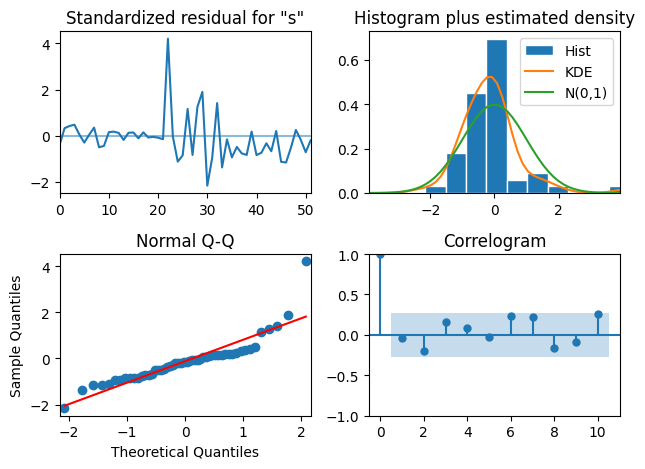

In [130]:
# Plot model diagnostics
arimax_result.plot_diagnostics()
plt.tight_layout()
plt.show()

In [131]:
# Print model summary and MSE
print(f"\nTest Set MSE: {arimax_mse}")
print("\nModel Summary:")
print(arimax_result.summary())


Test Set MSE: 203.36439658330303

Model Summary:
                               SARIMAX Results                                
Dep. Variable:           smoke_metric   No. Observations:                   53
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -239.211
Date:                Wed, 30 Oct 2024   AIC                            492.423
Time:                        20:55:08   BIC                            506.082
Sample:                             0   HQIC                           497.659
                                 - 53                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
GIS_Acres         7.543e-08   5.17e-12   1.46e+04      0.000    7.54e-08    7.54e-08
Shape_Area        3.926e-08   4.36e-09      8.999      0.000   

The diagnostics are mostly consistent.

1. The standardized residuals plot on the top left shows that fairly many records are around the 0 mark showing slight deviations from narmality. 
2. The histogram and density plot on the top right shows that the residuals are mostly centered around 0. There is slight deviation from a normal distribution.
3. The Q-Q plot on the bottom left shows that the ordered distribution of residuals is following a roughly linear trend meaning that the residuals are fairly normally distributed.
4. The correlogram on the bottom right shows that the residuals have low auto-correlation among itself.

This model seems useable from this.

Further, all the fields added except for avg_dist have a p-value of less than 0.05. This means that they are significant in predicting the AQI values. This is a good sign. The goodness of fit test, "Jarque-Bera" test, is far from zero. This means that the residuals are not normally distributed. I feel this model is still usable given all the other observations.

Next, I plot the AMIMAX model along with the 95% confidence interval. 


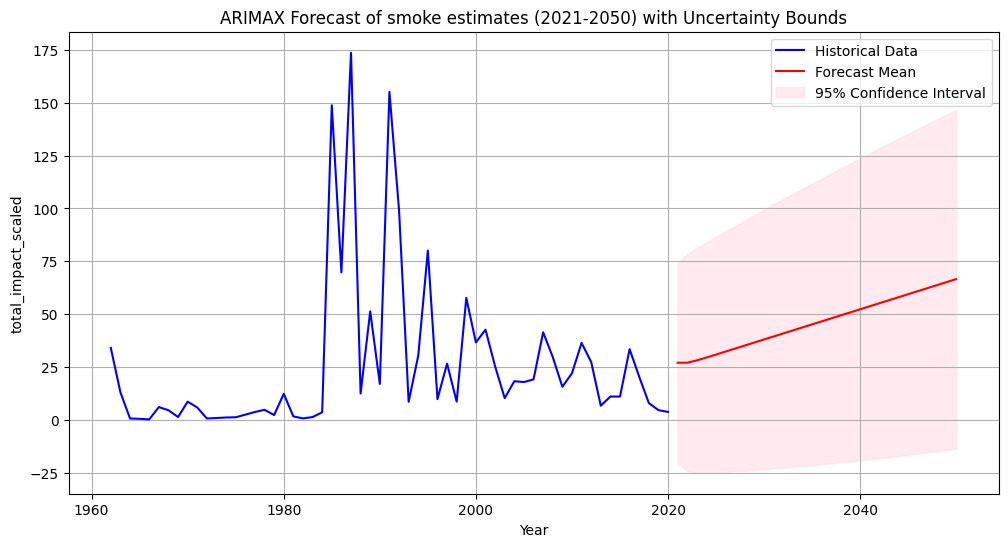

In [125]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(merged_df['Fire_Year'], endog, label='Historical Data', color='blue')

# Plot forecast
plt.plot(future_years.index, forecast_mean, label='Forecast Mean', color='red')

# Plot confidence intervals
plt.fill_between(
    future_years.index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title("ARIMAX Forecast of smoke estimates (2021-2050) with Uncertainty Bounds")
plt.xlabel("Year")
plt.ylabel("total_impact_scaled")
plt.legend()
plt.grid(True)
plt.show()